In [1]:
import os.path as path
import skimage.io as io
import numpy as np
import scipy as sp
import skimage
from skimage import color
from skimage import util
import skimage.filters as filters
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy import signal
from scipy.interpolate import interp1d
from skimage import color
import cv2
from sksparse.cholmod import cholesky,cholesky_AAt
from scipy.interpolate import RegularGridInterpolator

from task4_grad_domain import img2grad_field, reconstruct_grad_field


#https://github.com/yig/PySPQR
import sparseqr

## Step 1: Imaging Operator - Gradient Domain Optimisations

Define a image operator, which will be used to apply to the down-sampled input image. The low resolution Input/Output image produced will be used to fit an bilateral grid of affine models. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No. of pixels:  61440
cholesky  time: 0.11623787879943848


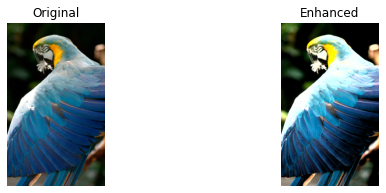

In [2]:
def optGrad(im):
    im = skimage.img_as_float(im)

    im_gray = color.rgb2gray(im)

    G = img2grad_field(im_gray)

    x_in = 0.4
    m = 2

    x = np.arange(-2.0, 2.0, 0.1)
    y = m*x
    f1 = interp1d(x, y)

    m2 = (m*x_in -1)/(x_in - 1)
    y2 = m2*x + (1-m2)
    f2 = interp1d(x, y2)

    G_enhanced = np.zeros(G.shape)
    G_enhanced = np.where(G < x_in, f1(G), f2(G))

    print("No. of pixels: ", G.shape[0]*G.shape[1])

    Gm = np.sqrt(np.sum(G_enhanced*G_enhanced, axis=2))
    w = 1/(Gm + 0.0001)     # to avoid pinching artefacts
    imr = reconstruct_grad_field(G_enhanced,w,im_gray[0,0], im_gray, "cholesky").clip(0,1)
    # imr = reconstruct_grad_field(G_enhanced,w,im_gray[0,0], im_gray, "sp").clip(0,1)

    imr_col = im.copy()
    c = imr/(im_gray+ 0.0001) # 0.0001 to avoid diversion by 0
    for i in range(0,3):
        imr_col[:,:,i] = im[:,:,i]*c


    plt.figure(figsize=(9, 3))

    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(im)

    plt.subplot(122)
    plt.title('Enhanced')
    plt.axis('off')
    plt.imshow(imr_col)

    plt.show()
    return imr_col


lowr = io.imread(path.join('images','low_res_in.png'))
lowr_enhanced = optGrad(lowr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


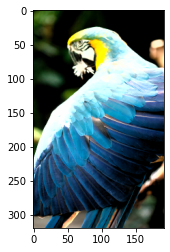

In [3]:
plt.imshow(lowr_enhanced)

## Step 2: Fit Affine model
Fitting a bilateral grid of affine models to the low resolution Input/Output pair
- Contruct bilateral grid: https://people.csail.mit.edu/sparis/publi/2007/siggraph/Chen_07_Bilateral_Grid.pdf
- matching reconstruction(trilinear) filter can be expressed as  StBSx: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/44003.pdf
- affine matrices:
https://people.csail.mit.edu/sparis/publi/2009/sigasia/Bousseau_09_User-assisted_Intrinsic_Images.pdf

In [4]:
#grid creation
#blurring
#slicing
lowr_enhanced.shape

(320, 192, 3)

In [5]:
lowr.shape

(320, 192, 3)

In [6]:
input_image = lowr
output_image = lowr_enhanced
grid_size = [20, 15, 10]
affine_size = [3,4] #(num of output channel) (num of input channel + 1) 

input_height = input_image.shape[1];
input_width = input_image.shape[0];
grid_height = grid_size[0];
grid_width = grid_size[1];
grid_depth = grid_size[2];

affine_output_size = affine_size[0]; #(num of output channel)
affine_input_size = affine_size[1];  #(num of input channel + 1)

In [7]:
#b_data output img we are trying to match
#rearrange into [red0 red1 ... redN green0 green1 ... greenN blue0 blue1 ... blueN]
b_data = output_image.flatten('F')
b_data

array([0.01565419, 0.03443423, 0.05012555, ..., 0.        , 0.        ,
       0.        ])

In [8]:
#edge_img is the input image illuminious
edge_img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
edge_img = cv2.normalize(edge_img, edge_img, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

In [9]:
edge_img[100][100]

0.8070866141732284

### For each component in the affine model (i,j):
- Build the matrices that slices out a particular (i,j) component of the affine model stored in a 3D bilateral grid using trilinear interpolation.
- Total 12 components

#### weight matrix: 
Generate weight with guidance image
guided filter:http://kaiminghe.com/eccv10/

In [10]:
def getWeightMatrix(grid_size, input_img, arg_edge_img):
#     num_grid_cells = 3*3*3*3*4 #20*15*10
#     grid_width = 3 #15 
#     grid_height = 3 #20
#     grid_depth = 3 #10
#     grid_affine_input_size = 4
#     grid_affine_output_size = 3
#     img_width = 5 #192 
#     img_height = 5 #320
#     num_pixels = img_width*img_height
#     edge_img = np.ones([img_width, img_height]) #toy edge image
    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width - 1)) * grid_width
    bg_coordy = ((pixel_y + 0.5)/(img_height - 1)) * grid_height
    bg_coordz = edge_img * (grid_depth - 1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z

    #compute dxdydz: distance of each point from the integeral bilateral grid coordinate
    dx = np.tile((bg_coordx - bg_int_x),(img_height, 1))
    dy = np.repeat((bg_coordy - bg_int_y).reshape(img_height,1),img_width,axis = 1)
    dz = bg_coordz - bg_int_z
    
    # Each weight_{x}{y}{z} is an image (height x width) ??
    w_000 = np.multiply ((1 - dx),(1 - dy),(1 - dz)).reshape(num_pixels,1)
    w_100 = np.multiply ((    dx),(1 - dy),(1 - dz)).reshape(num_pixels,1)
    w_010 = np.multiply ((1 - dx),(    dy),(1 - dz)).reshape(num_pixels,1)
    w_110 = np.multiply ((    dx),(    dy),(1 - dz)).reshape(num_pixels,1)
    w_001 = np.multiply ((1 - dx),(1 - dy),(    dz)).reshape(num_pixels,1)
    w_101 = np.multiply ((    dx),(1 - dy),(    dz)).reshape(num_pixels,1)
    w_011 = np.multiply ((1 - dx),(    dy),(    dz)).reshape(num_pixels,1)
    w_111 = np.multiply ((    dx),(    dy),(    dz)).reshape(num_pixels,1)
    
    
    w_i = np.tile(range(num_pixels),(8, 1)).reshape(num_pixels*8)
    w_j = np.array(range(num_pixels*8)).reshape(num_pixels*8) #sparse matrix y coordinate
    w_val = np.squeeze(np.concatenate([w_000,w_100,w_010,w_110,w_001,w_101,w_011,w_111]))
    w_m = num_pixels
    w_n = num_pixels*8
    
    weight = sparse.csr_matrix((w_val,(w_i,w_j)),
                 shape = (w_m,w_n))
    
    total_weight = sparse.block_diag((weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight))
    
    return total_weight

grid_size = [15,20,10,4,3]
weight_matrix = getWeightMatrix(grid_size,input_image,edge_img)

#### slice matrix: 

In [12]:
def getSliceMatrix(grid_size, input_img, arg_edge_img):
    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width - 1)) * grid_width
    bg_coordy = ((pixel_y + 0.5)/(img_height - 1)) * grid_height
    bg_coordz = edge_img * (grid_depth - 1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z

    #compute dxdydz: distance of each point from the integeral bilateral grid coordinate
    dx = np.tile((bg_coordx - bg_int_x),(img_height, 1))
    dy = np.repeat((bg_coordy - bg_int_y).reshape(img_height,1),img_width,axis = 1)
    dz = bg_coordz - bg_int_z
    
    
    st_indice = np.array(range(num_pixels*8))
    st_bg_x = np.concatenate(((bg_int_x_img + 0), (bg_int_x_img + 1),(bg_int_x_img + 0),(bg_int_x_img + 1), (bg_int_x_img + 0),(bg_int_x_img + 1),(bg_int_x_img + 0), (bg_int_x_img + 1))).reshape(num_pixels*8,1)
    st_bg_y = np.concatenate(((bg_int_y_img + 0), (bg_int_y_img + 0),(bg_int_y_img + 1),(bg_int_y_img + 1), (bg_int_y_img + 0),(bg_int_y_img + 0),(bg_int_y_img + 1), (bg_int_y_img + 1))).reshape(num_pixels*8,1)
    st_bg_z = np.concatenate(((bg_int_z_img + 0), (bg_int_z_img + 0),(bg_int_z_img + 0),(bg_int_z_img + 0), (bg_int_z_img + 1),(bg_int_z_img + 1),(bg_int_z_img + 1), (bg_int_z_img + 1))).reshape(num_pixels*8,1)
    
    st_list = []
    for j in range(grid_affine_input_size):
        for i in range(grid_affine_output_size):
            st_bg_u = i * np.ones((num_pixels*8, 1))
            st_bg_v = j * np.ones((num_pixels*8, 1))
            st_s = np.ones((num_pixels*8, 1))

            indices = (st_bg_x >= 0) & (st_bg_x < grid_width) & (st_bg_y >= 0) & (st_bg_y < grid_height)& (st_bg_z >= 0) & (st_bg_z < grid_depth)

            indices=np.squeeze(indices)
            st_ii = st_indice[indices]
            st_bg_xx = st_bg_x[indices].astype(int)
            st_bg_yy = st_bg_y[indices].astype(int)
            st_bg_zz = st_bg_z[indices].astype(int)
            st_bg_uu = st_bg_u[indices].astype(int)
            st_bg_vv = st_bg_v[indices].astype(int)

            st_val = st_s[indices].astype(int)#all ones
            
            st_jj_dim = [grid_height, grid_width, grid_depth, grid_affine_output_size, grid_affine_input_size]
            st_jj = np.ravel_multi_index([st_bg_yy, st_bg_xx, st_bg_zz, st_bg_uu, st_bg_vv], dims=st_jj_dim, order='F')

            st_val = np.squeeze(st_val)
            st_ii = np.squeeze(st_ii)
            st_jj = np.squeeze(st_jj)

            st_m = 8 * num_pixels
            st_n = num_grid_cells
            st = sparse.csr_matrix((st_val,(st_ii,st_jj)),shape = (st_m,st_n))
            
            st_list.append(st)
            
    slice_matrix = sparse.vstack([st_list[0],st_list[1],st_list[2],st_list[3],st_list[4],st_list[5],st_list[6],st_list[7],st_list[8],st_list[9],st_list[10],st_list[11]])
    return slice_matrix

# grid_size = [15,20,10,4,3]
slice_matrix = getSliceMatrix(grid_size,input_image,edge_img)

#### Prepare input matrice for fitting affine model

In [13]:
def getOrganisedInputImg(input_img, num_of_output_channels):

    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    num_of_output_channels = 3
    prepare_input = []
    for k in range(3):
        plane = input_img[:,:,k]
        plane_flat = plane.flatten()
        plane_flat = np.tile(plane_flat,num_of_output_channels) #repeat (number of output channel) times
        color_channel = sparse.diags(plane_flat)
        prepare_input.append(color_channel)

    #add affine dimensions, for offset in linear model
    empty_channel = sparse.diags(np.ones(num_pixels*num_of_output_channels))
    prepare_input.append(empty_channel)

    prepared_input = sparse.hstack([prepare_input[0],prepare_input[1],prepare_input[2],prepare_input[3]])
    return prepared_input

organised_input_img = getOrganisedInputImg(input_image, grid_size[-1])

#### Prepare b_data (output image)

In [14]:
output_weight = np.ones(output_image.shape)
sqrt_w = np.sqrt(output_weight.flatten())
b_data = np.multiply(output_image.flatten(),sqrt_w)

#### Prepare A_data

In [15]:
print(organised_input_img.shape)
print(weight_matrix.shape)
print(slice_matrix.shape)

output_weight_diag_matrix = sparse.diags(sqrt_w)
A_data = output_weight_diag_matrix * organised_input_img * weight_matrix * slice_matrix

print(A_data.shape)
print(b_data.shape)

(184320, 737280)
(737280, 5898240)
(5898240, 36000)
(184320, 36000)
(184320,)


In [16]:
# x, istop, itn, r1norm = sparse.linalg.lsqr(A_data, b_data, show=True) #too slow didn't work

#SPQR: multifrontal QR.  Appears as QR and x=A\b in MATLAB, with CUDA acceleration.
x = sparseqr.solve(A_data, b_data,tolerance = 0)

In [17]:
x

array([-0.01467184,  0.00326132, -0.00926325, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
gamma = x

In [19]:
grid_size = [15,20,10,4,3]
gamma = np.reshape(gamma, grid_size);

#### Given an affine model and a (high-resolution) image, applies the model, producing a (high-resolution) result.

In [20]:
highr_input = io.imread(path.join('images','high_res_in.png'))

In [21]:
input_img = highr_input
grid_size = [15,20,10,4,3]
edge_img = edge_img


grid_width = grid_size[0]
grid_height = grid_size[1]
grid_depth = grid_size[2]
grid_affine_input_size = grid_size[3]
grid_affine_output_size = grid_size[4]
img_width = input_img.shape[1]#192
img_height = input_img.shape[0]#320
num_pixels = img_width*img_height

# meshgrid inputs and outputs 
[x,y] = np.meshgrid(range(img_width),range(img_height))

# Downsample x and y to grid space
bg_coord_x = ((x + 0.5) * (grid_width - 1) / input_width);
bg_coord_y = ((y + 0.5) * (grid_height - 1) / input_height);
bg_coord_z = edge_img * (grid_depth - 1);

bg_coord_x.shape
#interp
x = np.linspace(1, grid_width, grid_width)
y = np.linspace(1, grid_height, grid_height)
z = np.linspace(1, grid_depth, grid_depth)

affine_model = np.zeros([grid_affine_output_size, grid_affine_input_size]);

# print(gamma.shape)
for j in range (1):
    for i in range (1):
        print(gamma[:,:,:,i,j].shape)
        fn = RegularGridInterpolator((x,y,z), gamma[:,:,:,i,j])
        points = [bg_coord_x, bg_coord_y, bg_coord_z]
        affine_model[i][j] = fn(points)

(15, 20, 10)


/home/elim/anaconda3/envs/graphics/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
x

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])